In [1]:
from datetime import date
print(date.today())

2023-05-04


# 1. Normalisation & variance stabilisation

Objectives: 

1. Explain rationale behind normalisation/variance stabilisation
1. List options for normalisation/variance stabilisation
1. Explain their preference for one
1. Normalise a dataset
1. Demonstrate that the normalisation achieved the intended effect

### 1.1 Why is normalisation important?

- have students run without normalisation and see what happens.
- does normalisation distort/enhance biological signal?
- literature about normalisation:
    - [Comparison of transformations for single-cell RNA-seq data](https://www.nature.com/articles/s41592-023-01814-1)
    - [Validation of noise models for single-cell transcriptomics](https://www.nature.com/articles/nmeth.2930)
    - [The triumphs and limitations of computational methods for scRNA-seq](https://www.nature.com/articles/s41592-021-01171-x)
    - [Absolute scaling of single-cell transcriptomes identifies pervasive hypertranscription in adult stem and progenitor cells](https://www.cell.com/cell-reports/fulltext/S2211-1247(22)01882-4?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2211124722018824%3Fshowall%3Dtrue)

### 1.2 How do we normalise?

- challenge them to think about what we need. What does it mean if we normalise?
- What do we want to achieve with normalisation? Do we get it?
- Literature:
    - [Normalisation of single-cell RNA-seq counts by log(x+1)](https://academic.oup.com/bioinformatics/article/37/15/2223/6155989)
    - [Normalization and variance stabilization of single-cell RNA-seq data using regularized negative binomial regression](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)
    - [Depth normalization for single-cell genomics count data](https://www.biorxiv.org/content/10.1101/2022.05.06.490859v1.full)

### 1.3 How do we evaluate if it worked?

- gold standard
- simulated data
- expert knowledge


Let's start by importing our dataset:

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import scanpy as sc

In [3]:
retina = "/Users/npapadop/Documents/teaching/2023/advanced_scRNAseq/data/chicken retina/"
raw = sc.read_h5ad(retina + "e16_raw.h5ad")

In [4]:
sc.pp.filter_genes(raw, min_cells=3)

Let's also keep track of some basic attributes for each cell and each gene so that we can refer to
them later:

In [5]:
sc.pp.calculate_qc_metrics(raw, percent_top=None, inplace=True)
raw.var["var_counts"] = np.var(raw.X, axis=0)

## 1.1 Why is normalisation important?

What happens if we don't normalize? What would we expect?

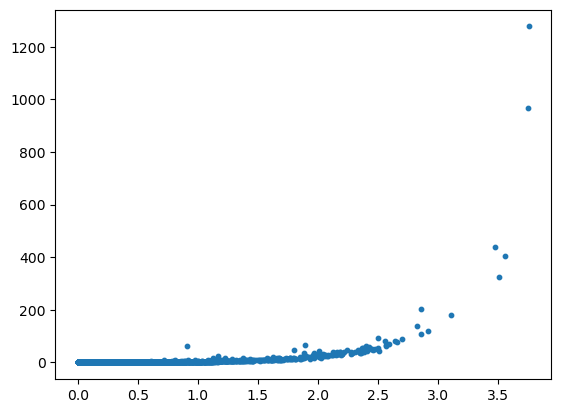

In [6]:
raw_mean = np.mean(raw.X, axis=0)
raw_var = np.var(raw.X, axis=0)

fig, ax = plt.subplots()
ax.scatter(np.log1p(raw_mean), raw_var, s=10)

Why is this bad? What does it mean in terms of distances? Let's plot the expression range of a
highly expressed gene and that of a gene with low average expression.

In [7]:
def approximately_equal(x, y, tol=0.01):
    return abs(x - y) < tol

In [8]:
np.where(np.apply_along_axis(approximately_equal, 0, raw_var, 60, tol=5))

(array([ 2426,  5321,  9360, 12519, 13217, 14819, 15423, 16114]),)

In [14]:
# plot_discrete_histogram(raw, 1557)
fake_gene = raw.X[:, 1557].copy()
inflate = np.random.randint(0, len(fake_gene), 200)
fake_gene[inflate] += 40

In [10]:
def plot_discrete_histogram(adata, gene, ax=None):
    x = adata[:, gene].X
    xx = np.unique(x)
    y = np.array([np.sum(x == i) for i in xx])
    if ax is None:
        plt.bar(xx, y)
        plt.title(f"gene {gene}")
    else:
        ax.bar(xx, y)
        ax.set_title(f"gene {gene}")

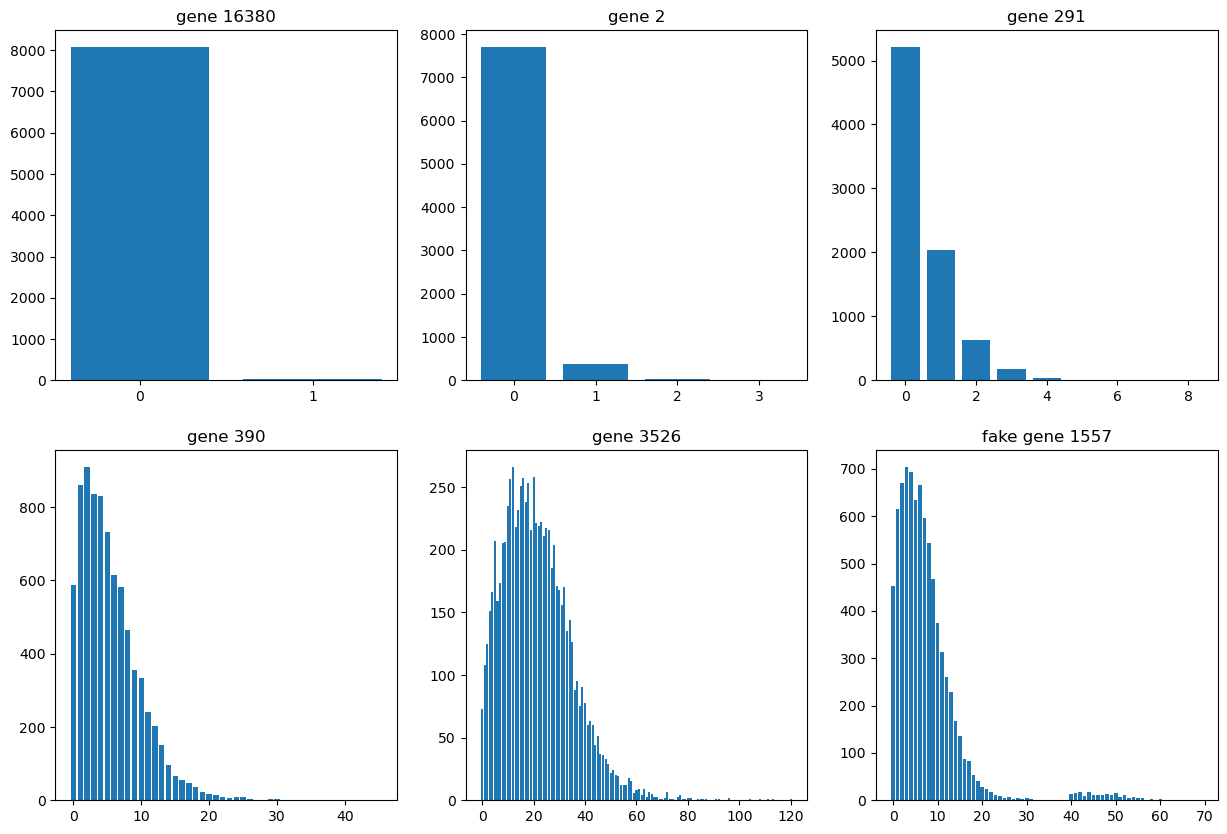

In [15]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
plot_discrete_histogram(raw, 16380, ax=ax[0, 0])
ax[0, 0].xaxis.set_ticks([0, 1])
plot_discrete_histogram(raw, 2, ax=ax[0, 1])
plot_discrete_histogram(raw, 291, ax=ax[0, 2])
plot_discrete_histogram(raw, 390, ax=ax[1, 0])
plot_discrete_histogram(raw, 3526, ax=ax[1, 1])
# a fake bimodal gene
xx = np.unique(fake_gene)
y = np.array([np.sum(fake_gene == i) for i in xx])
ax[1,2].bar(xx, y)
ax[1,2].set_title("fake gene 1557");

In [19]:
raw.shape

(8107, 16386)

In [24]:
cherrypicked = np.zeros((raw.shape[0], 6))

cherrypicked[:, :5] = raw.X[:, [16380, 2, 291, 390, 3526]].copy()
cherrypicked[:, 5] = fake_gene.copy()

In [51]:
toy = sc.AnnData(cherrypicked)
faked = np.zeros(toy.shape[0], dtype=str)
faked[inflate] = "1"
toy.obs["faked"] = faked.copy()

In [53]:
sc.pp.pca(toy)
sc.pp.neighbors(toy, n_neighbors=5, metric="euclidean")
sc.tl.umap(toy)

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


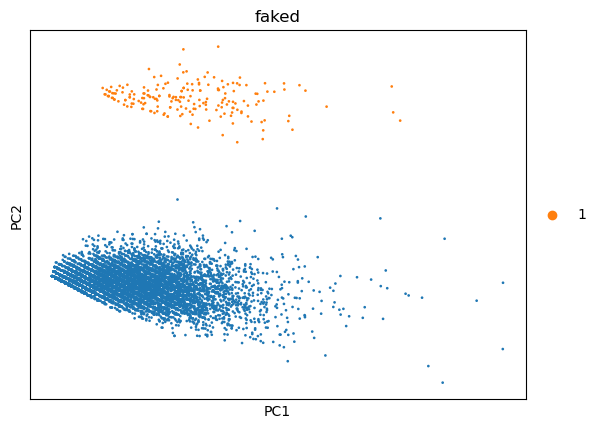

In [55]:
sc.pl.pca(toy, color="faked")

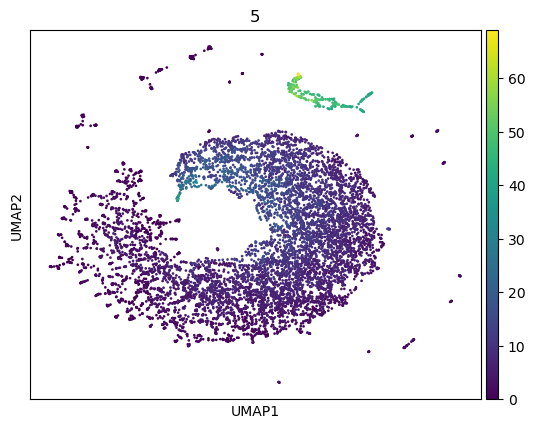

In [56]:
sc.pl.umap(toy, color="5")

/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/npapadop/mambaforge/envs/ascc23/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


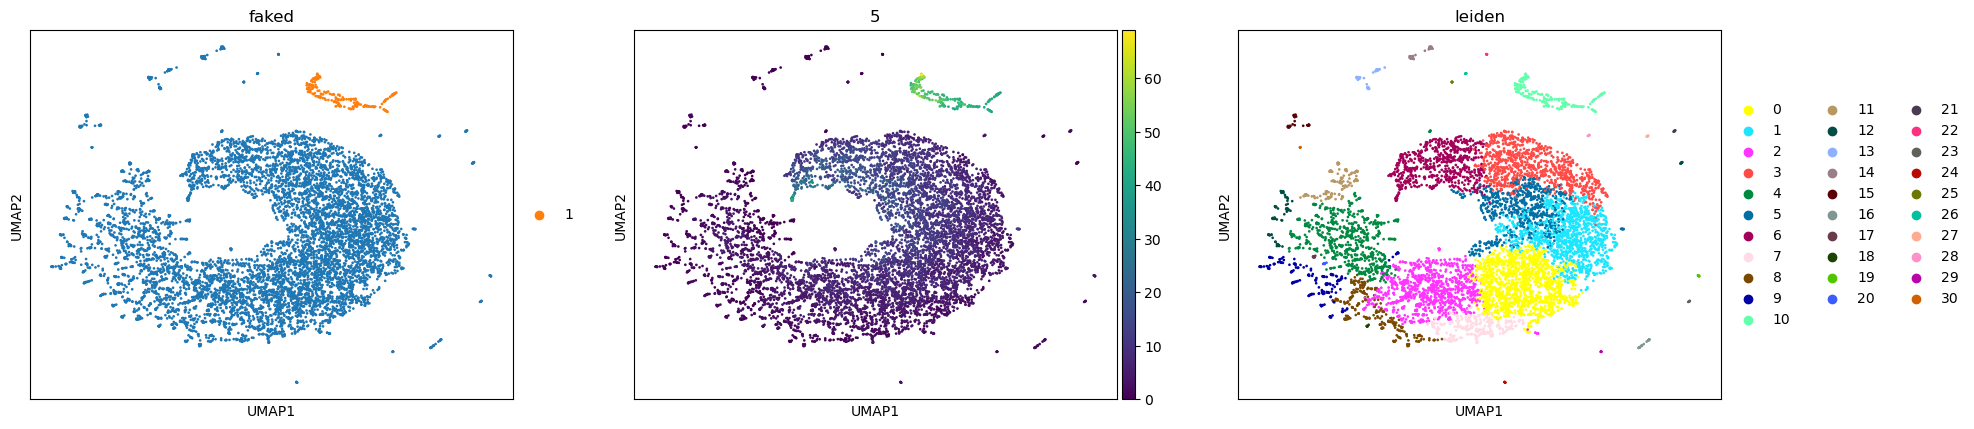

In [66]:
sc.pl.umap(toy, color=["faked", "5", "leiden"])